In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [2]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
# val_csv = config.val_csv
# val_dir = config.val_dir

In [3]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [4]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

# eval_dataset = SiameseDataset(
#     val_csv,
#     val_dir,
#     transform=transforms.Compose(
#         [transforms.Resize((105, 105)), transforms.ToTensor()]
#     ),
# )

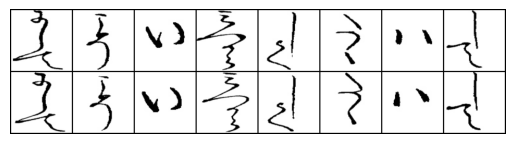

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [5]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        # self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features

        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output

In [8]:
# train the model
def train(model, device, optimizer, train_dataloader, train_losses, t_correct_set):
    criterion = nn.BCELoss()
    model.train()
    train_loss = 0
    correct = 0

    for _, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)
        train_loss += loss
        loss.backward()
        optimizer.step()
        pred = torch.where(
            outputs > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()

    train_loss /= len(train_dataloader.dataset)
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            train_loss,
            correct,
            len(train_dataloader.dataset),
            100.0 * correct / len(train_dataloader.dataset),
        )
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    t_correct_set.append(correct / len(train_dataloader.dataset))
    return train_loss


def eval(model, device, test_dataloader, val_losses, v_correct_set):
    criterion = nn.BCELoss()
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images_1, images_2, targets in test_dataloader:
            images_1, images_2, targets = (
                images_1.to(device),
                images_2.to(device),
                targets.to(device),
            )
            outputs = model(images_1, images_2)
            val_loss += criterion(outputs, targets).sum().item()
            pred = torch.where(
                outputs > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(test_dataloader.dataset)

    print(
        "\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            val_loss,
            correct,
            len(test_dataloader.dataset),
            100.0 * correct / len(test_dataloader.dataset),
        )
    )
    val_losses.append(val_loss)
    v_correct_set.append(correct / len(test_dataloader.dataset))

    return val_loss

In [9]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
# eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = nn.BCELoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
val_losses = []
train_losses = []
t_correct_set = []
v_correct_set = []
best_eval_loss = 999
# eval(model, device, eval_dataloader)
for epoch in tqdm(range(1, config.epochs)):
    train_loss = train(
        model, device, optimizer, train_dataloader, train_losses, t_correct_set
    )
    val_loss = eval(model, device, test_dataloader, val_losses, v_correct_set)

    print("-" * 20)

    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        print(f"Best Eval loss: {best_eval_loss}")
        torch.save(model.state_dict(), "../siamese/content/model_BCE.pth")
        print("Model Saved Successfully")
        print("-" * 20)

  0%|          | 0/29 [00:00<?, ?it/s]


Train set: Average loss: 0.0176, Accuracy: 4654/6293 (74%)


  3%|▎         | 1/29 [00:19<08:53, 19.04s/it]


Val set: Average loss: 0.0164, Accuracy: 1179/1574 (75%)
--------------------
Best Eval loss: 0.01642006059594954
Model Saved Successfully
--------------------

Train set: Average loss: 0.0141, Accuracy: 4962/6293 (79%)


  7%|▋         | 2/29 [00:37<08:21, 18.59s/it]


Val set: Average loss: 0.0131, Accuracy: 1291/1574 (82%)
--------------------
Best Eval loss: 0.013065576666949514
Model Saved Successfully
--------------------

Train set: Average loss: 0.0122, Accuracy: 5195/6293 (83%)


 10%|█         | 3/29 [00:54<07:51, 18.13s/it]


Val set: Average loss: 0.0133, Accuracy: 1262/1574 (80%)
--------------------

Train set: Average loss: 0.0113, Accuracy: 5343/6293 (85%)


 14%|█▍        | 4/29 [01:11<07:21, 17.65s/it]


Val set: Average loss: 0.0157, Accuracy: 1217/1574 (77%)
--------------------

Train set: Average loss: 0.0104, Accuracy: 5433/6293 (86%)


 17%|█▋        | 5/29 [01:29<07:08, 17.84s/it]


Val set: Average loss: 0.0243, Accuracy: 1194/1574 (76%)
--------------------

Train set: Average loss: 0.0102, Accuracy: 5457/6293 (87%)


 21%|██        | 6/29 [01:46<06:39, 17.37s/it]


Val set: Average loss: 0.0102, Accuracy: 1363/1574 (87%)
--------------------
Best Eval loss: 0.010186617197575382
Model Saved Successfully
--------------------

Train set: Average loss: 0.0093, Accuracy: 5540/6293 (88%)


 24%|██▍       | 7/29 [02:03<06:22, 17.38s/it]


Val set: Average loss: 0.0106, Accuracy: 1341/1574 (85%)
--------------------

Train set: Average loss: 0.0089, Accuracy: 5587/6293 (89%)


 28%|██▊       | 8/29 [02:21<06:05, 17.39s/it]


Val set: Average loss: 0.0106, Accuracy: 1361/1574 (86%)
--------------------

Train set: Average loss: 0.0092, Accuracy: 5528/6293 (88%)


 31%|███       | 9/29 [02:38<05:45, 17.26s/it]


Val set: Average loss: 0.0163, Accuracy: 1219/1574 (77%)
--------------------

Train set: Average loss: 0.0086, Accuracy: 5594/6293 (89%)


 34%|███▍      | 10/29 [02:54<05:24, 17.10s/it]


Val set: Average loss: 0.0086, Accuracy: 1399/1574 (89%)
--------------------
Best Eval loss: 0.008625635420465712
Model Saved Successfully
--------------------

Train set: Average loss: 0.0080, Accuracy: 5686/6293 (90%)


 38%|███▊      | 11/29 [03:11<05:04, 16.89s/it]


Val set: Average loss: 0.0091, Accuracy: 1392/1574 (88%)
--------------------

Train set: Average loss: 0.0076, Accuracy: 5708/6293 (91%)


 41%|████▏     | 12/29 [03:28<04:47, 16.90s/it]


Val set: Average loss: 0.0092, Accuracy: 1380/1574 (88%)
--------------------

Train set: Average loss: 0.0079, Accuracy: 5685/6293 (90%)


 45%|████▍     | 13/29 [03:44<04:28, 16.76s/it]


Val set: Average loss: 0.0091, Accuracy: 1389/1574 (88%)
--------------------

Train set: Average loss: 0.0071, Accuracy: 5734/6293 (91%)


 48%|████▊     | 14/29 [04:01<04:09, 16.65s/it]


Val set: Average loss: 0.0073, Accuracy: 1424/1574 (90%)
--------------------
Best Eval loss: 0.0073066999641125206
Model Saved Successfully
--------------------

Train set: Average loss: 0.0065, Accuracy: 5805/6293 (92%)


 52%|█████▏    | 15/29 [04:17<03:51, 16.54s/it]


Val set: Average loss: 0.0074, Accuracy: 1430/1574 (91%)
--------------------

Train set: Average loss: 0.0065, Accuracy: 5795/6293 (92%)


 55%|█████▌    | 16/29 [04:34<03:38, 16.79s/it]


Val set: Average loss: 0.0069, Accuracy: 1424/1574 (90%)
--------------------
Best Eval loss: 0.006904154613595148
Model Saved Successfully
--------------------

Train set: Average loss: 0.0066, Accuracy: 5758/6293 (91%)


 59%|█████▊    | 17/29 [04:52<03:23, 16.96s/it]


Val set: Average loss: 0.0068, Accuracy: 1434/1574 (91%)
--------------------
Best Eval loss: 0.006822877612054878
Model Saved Successfully
--------------------

Train set: Average loss: 0.0057, Accuracy: 5852/6293 (93%)


 62%|██████▏   | 18/29 [05:08<03:03, 16.72s/it]


Val set: Average loss: 0.0094, Accuracy: 1400/1574 (89%)
--------------------

Train set: Average loss: 0.0054, Accuracy: 5874/6293 (93%)


 66%|██████▌   | 19/29 [05:24<02:46, 16.60s/it]


Val set: Average loss: 0.0094, Accuracy: 1384/1574 (88%)
--------------------

Train set: Average loss: 0.0056, Accuracy: 5847/6293 (93%)


 69%|██████▉   | 20/29 [05:41<02:29, 16.61s/it]


Val set: Average loss: 0.0066, Accuracy: 1442/1574 (92%)
--------------------
Best Eval loss: 0.006578230678921582
Model Saved Successfully
--------------------

Train set: Average loss: 0.0053, Accuracy: 5873/6293 (93%)


 72%|███████▏  | 21/29 [05:58<02:14, 16.84s/it]


Val set: Average loss: 0.0083, Accuracy: 1401/1574 (89%)
--------------------

Train set: Average loss: 0.0050, Accuracy: 5896/6293 (94%)


 76%|███████▌  | 22/29 [06:15<01:57, 16.85s/it]


Val set: Average loss: 0.0058, Accuracy: 1467/1574 (93%)
--------------------
Best Eval loss: 0.005848230124277262
Model Saved Successfully
--------------------

Train set: Average loss: 0.0045, Accuracy: 5968/6293 (95%)


 79%|███████▉  | 23/29 [06:33<01:42, 17.08s/it]


Val set: Average loss: 0.0103, Accuracy: 1356/1574 (86%)
--------------------

Train set: Average loss: 0.0044, Accuracy: 5968/6293 (95%)


 83%|████████▎ | 24/29 [06:50<01:25, 17.18s/it]


Val set: Average loss: 0.0056, Accuracy: 1453/1574 (92%)
--------------------
Best Eval loss: 0.005590876440128271
Model Saved Successfully
--------------------

Train set: Average loss: 0.0038, Accuracy: 6015/6293 (96%)


 86%|████████▌ | 25/29 [07:07<01:08, 17.14s/it]


Val set: Average loss: 0.0065, Accuracy: 1440/1574 (91%)
--------------------

Train set: Average loss: 0.0042, Accuracy: 5972/6293 (95%)


 90%|████████▉ | 26/29 [07:26<00:52, 17.54s/it]


Val set: Average loss: 0.0062, Accuracy: 1445/1574 (92%)
--------------------

Train set: Average loss: 0.0039, Accuracy: 5999/6293 (95%)


 93%|█████████▎| 27/29 [07:42<00:34, 17.20s/it]


Val set: Average loss: 0.0055, Accuracy: 1477/1574 (94%)
--------------------
Best Eval loss: 0.005460311642113074
Model Saved Successfully
--------------------

Train set: Average loss: 0.0035, Accuracy: 6031/6293 (96%)


 97%|█████████▋| 28/29 [08:00<00:17, 17.39s/it]


Val set: Average loss: 0.0053, Accuracy: 1471/1574 (93%)
--------------------
Best Eval loss: 0.005315986078225426
Model Saved Successfully
--------------------

Train set: Average loss: 0.0031, Accuracy: 6049/6293 (96%)


100%|██████████| 29/29 [08:17<00:00, 17.14s/it]


Val set: Average loss: 0.0059, Accuracy: 1465/1574 (93%)
--------------------


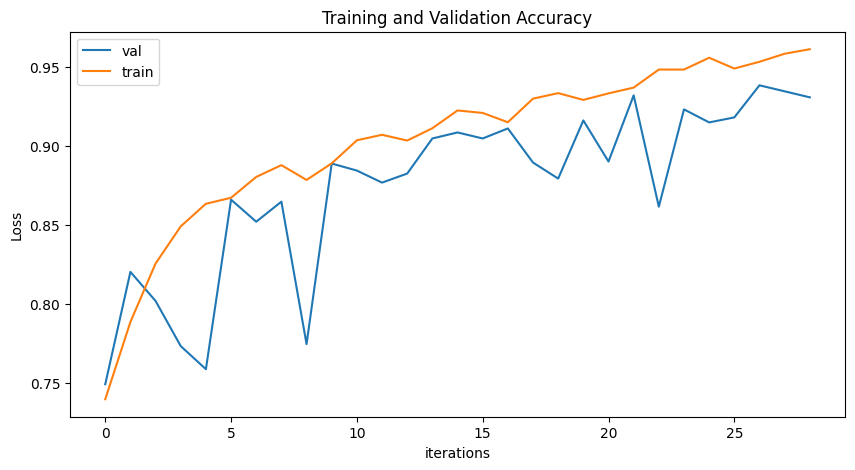

In [10]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(v_correct_set, label="val")
plt.plot(t_correct_set, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

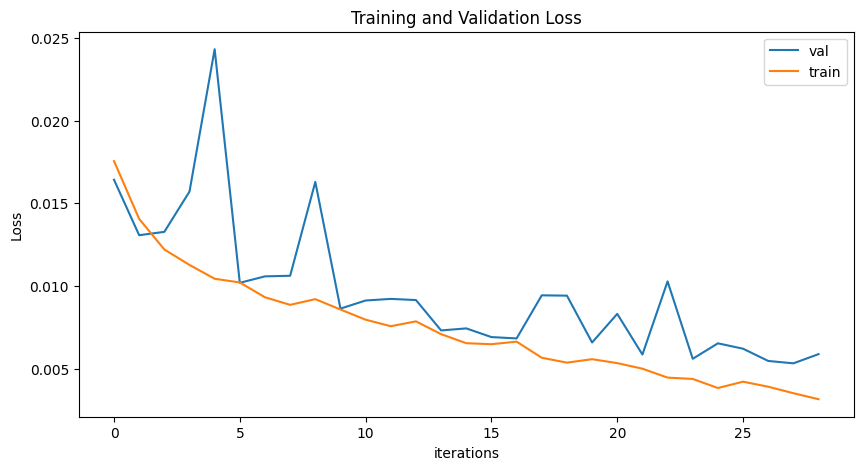

In [11]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        outputs = model(images_1, images_2)
        test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
        pred = torch.where(
            outputs > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss / len(test_dataloader.dataset),
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0058, Accuracy: 1465/1574 (93%)



In [13]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

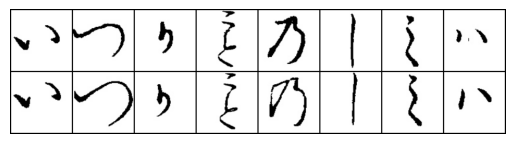

[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [14]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [15]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
outputs = model(images_1, images_2)
pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
correct += pred.eq(targets.view_as(pred)).sum().item()

In [16]:
outputs

tensor([[0.1367],
        [0.8221],
        [0.9936],
        [0.0018],
        [0.5671],
        [0.0199],
        [0.0078],
        [0.9985]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [17]:
pred

tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1]], device='cuda:0')

In [18]:
transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])


def transformation(transform, image1_path):
    img = Image.open(image1_path)
    img = img.convert("L")

    # Apply image transformations
    img = transform(img)
    return img

In [34]:
img1 = transformation(transform, "../dataset/1/1653_001_107_0.jpg").to(device)
img2 = transformation(transform, "../dataset/1/3548_001_115_0.jpg").to(device)

output = model(img1.unsqueeze(0), img2.unsqueeze(0))
output

tensor([[0.7621]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [27]:
img1 = transformation(
    transform, "/fs9/yuxiao/nii_project/dataset/char_block_4/あ/あ_1/2/3548_001_115_0.jpg"
).to(device)
img2 = transformation(
    transform, "/fs9/yuxiao/nii_project/dataset/char_block_4/あ/あ_1/4/6175_001_126_1.jpg"
).to(device)

output = model(img1.unsqueeze(0), img2.unsqueeze(0))
output

tensor([[0.0213]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
img1 = transformation(transform, "../dataset/1/1990_001_108_1.jpg").to(device)
img2 = transformation(transform, "../dataset/1/266_001_100_1.jpg").to(device)

output = model(img1.unsqueeze(0), img2.unsqueeze(0))
output

tensor([[0.0408]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
img1 = transformation(transform, "../dataset/1/462_001_101_1.jpg").to(device)
img2 = transformation(transform, "../dataset/1/10640_001_145_0.jpg").to(device)

output = model(img1.unsqueeze(0), img2.unsqueeze(0))
output

tensor([[0.0036]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [23]:
img1 = transformation(transform, "../dataset/1/4612_001_11_0.jpg").to(device)
img2 = transformation(transform, "../dataset/1/29655_001_6_0.jpg").to(device)

output = model(img1.unsqueeze(0), img2.unsqueeze(0))
output

tensor([[0.0990]], device='cuda:0', grad_fn=<SigmoidBackward0>)